<a href="https://colab.research.google.com/github/lscheu2806/iannwtf/blob/main/homework02_freichwald_lscheu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np

## 1 Preparation

### What is the purpose of an activation function in NN in general

First, let's quickly recap: Neural Networks are networks of neurons. Each neuron receives potentials from other neurons (or other sources, e.g. photoreceptors), which influence its own potential. This potential needs to reach a certain *threshold* to "fire" again, i.e. to send the signal forward. In general, the task of the *threshold* is to differentiate between *noise* and important *stimulus*.  
Conceptually, a neuron in an ANN serves the same purpose: *Sum up incoming information, decide whether the input is noise or stimulus and decide to fire*. This is all encompassed by the activation function. 

### What's the advantage of e.g. sigmoid over the step function (threshold function)

Step function: $$\sigma(x) := y = \begin{cases} 1\text{ for }x\geq 0 \\ 0 \text{ for } x < 0 \end{cases}$$  
(see sigmoid below)  
In a nut shell, while the step function is biologically motivated and simple to implement, the big disadvantage is that it's derivative is 0 everywhere. Since we need a derivative for our gradient descent approach to optimization, we should choose an activtion function that's derivative contains valuable information: A very popular alternative is the sigmoid function. Another advantage is that the sigmoid function also adheres to the *Universal Approximation Theorem*, which in summary just states that an MLP with one hidden layer can approximate any (real) function given enough neurons in this hidden layer. Neat. 

### What does sigmoid look like (the formula as well as the graph)?

Sigmoid: $$\sigma(x) = \frac{1}{1+e^{-x}}$$  
For Sigmoid-prime (derivative), see below. 
![sig.png](attachment:sig.png)

### What is the derivative of sigmoid 

$$\frac{d}{dx} \sigma=\sigma'(x) = \sigma(x)(1-\sigma(x))$$

In [5]:
# Super simple sigmoid, no error handling, using the already importet numpy exponent 
# function instead of loading the extra python math module. 
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

In [6]:
# Simply using the above definition of sigmoidprime and our priorly defined sigmoid function.
def sigmoidprime(x):
    return sigmoid(x)*(1-sigmoid(x))

## 2 Data set

In [7]:
# Permutate all posibilities
data = np.array([[0,0],[0,1],[1,0],[1,1]], dtype = np.float32) 
# Correct labels for all 5 logic tasks 
lab_and = np.array([0,0,0,1], dtype = np.float32)
lab_or = np.array([0,1,1,1], dtype = np.float32)
lab_notand = np.array([1,1,1,0], dtype = np.float32)
lab_notor = np.array([1,0,0,0], dtype = np.float32)
lab_xor = np.array([0,1,1,0], dtype = np.float32)

## 3 Perceptron 

In [44]:
class Perceptron:
    # Initializing the perceptron with the right number of inputs (input_units)
    def __init__(self, input_units):
        self.input_units = input_units
        # Initialize random weights and a random bias term.
        self.weights = np.random.randn(input_units)
        self.bias = np.random.randn()
        # Setting the learning rate to 1
        self.alpha = 1
        
    def forward_step(self, inputs):
        # Saves the input for later backpropagation
        self.inputs = inputs
        # Calculates the weighted input and returns it after using the activation function, in this case sigmoid
        self.weighted_sum = self.weights @ inputs + self.bias
        return sigmoid(self.weighted_sum)
        
    def update(self, delta):
        # Updating the weights and bias using delta
        gradient = delta * self.inputs
        self.weights = self.weights - self.alpha * gradient
        self.bias = self.bias - self.alpha * delta

## 5 Multi-Layer-Perceptron

In [48]:
# Here we use the perceptrons to build a multi layer perceptron
class MLP:
    def __init__(self, nPerc, nInputs):
        # Building a hidden layer with nPerc perceptrons, these have a certain number of inputs defined by nInputs
        self.hidden = np.array([Perceptron(nInputs) for i in range(nPerc)])
        self.outputPerc = Perceptron(nPerc)
        
    def forward_step(self, inputs):
        # Calling in the hidden layer each perceptrons forawrd_step-function and saves the results in hiddenLayerOutput. 
        # Then we call the forward_step-function of the output perceptron and hand over the results of the hidden layer. The
        # result of the output perceptron will be saved in output
        self.hiddenLayerOutput = np.array([perc.forward_step(inputs) for perc in self.hidden])
        self.hiddenLayerOutput = np.reshape(self.hiddenLayerOutput, newshape=(-1))
        self.output = self.outputPerc.forward_step(self.hiddenLayerOutput)
        
    def backprop_step(self, label):
        # Calculates the delta for the output perceptron 
        deltaOutput = -(label - self.output) * sigmoidprime(self.outputPerc.weighted_sum)
        # Updates the output perceptron
        self.outputPerc.update(deltaOutput)
        # Calculates the delta for each perceptron in the hidden layer and updates it
        for i,perc in enumerate(self.hidden):
            delta = deltaOutput * sigmoidprime(perc.weighted_sum) * self.outputPerc.weights[i]
            perc.update(delta)

In [46]:
# Training function where we can choose
#   nPerc: number of perceptrons in the hidden layer
#   input_units : number of inputs to the hidden layer
#   epochs: number of epochs for the training
#   data: the data we use to train the mlp
#   labels: correct labels of the datapoints (labels the mlp is meant to learn)
# Additionaly the function takes record of the accuracy and losses.
def train(nPerc, inputs_units, epochs, data, labels):
  mlp = MLP(nPerc, inputs_units)
  epoList = range(1, epochs+1)
  lossList = []
  accList = []
  for i in epoList:
        print(f"Epoch {i} done")
        accuracy = 0
        loss = 0
        for j in range(0,len(data)):
            mlp.forward_step(data[j])
            mlp.backprop_step(labels[j])
            accuracy += 1 if (mlp.output < 0.5 and labels[j] == 0) or (mlp.output >= 0.5 and labels[j] == 1) else 0
            loss += (labels[j] - mlp.output)**2
        accList.append(accuracy/4)
        lossList.append(loss/4)
  return mlp, accList, lossList, epoList

trainedMLP, accList, lossList, epoList = train(4,2,1000, data, lab_xor)

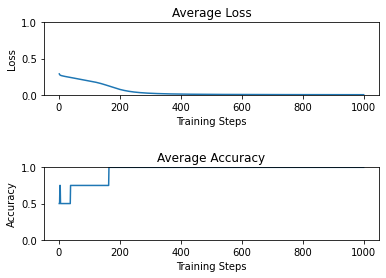

In [47]:
import matplotlib.pyplot as plt

# Visualizing the results (accuracy, losses) of the mlp using matplotlib
fig, axs = plt.subplots(2)
plt.subplots_adjust(hspace=1)
axs[0].plot(epoList, lossList)
axs[0].set_title("Average Loss")
axs[0].set(xlabel="Training Steps", ylabel="Loss")
axs[0].set_ylim(0, 1)

axs[1].plot(epoList, accList)
axs[1].set_title("Average Accuracy")
axs[1].set(xlabel="Training Steps", ylabel="Accuracy")
axs[1].set_ylim(0,1)
plt.show()